# Capstone Implementation

LangChain (core) + LangGraph (control) + RAG + Tools + LangSmith (tracing)

START
  =>
ingest (normalize + init)
  =>
classify_intent (LLM)
  =>
retrieve (RAG)
  =>
plan_tools (code)
  =>
run_tools (deterministic)
  =>
synthesize (LLM grounded)
  =>
validate (code)
  ├─ valid → END
  └─ invalid & retry_count < 2 → retrieve (loop)
  └─ invalid & retry_count == 2 → escalate → END
**bold text**

In [1]:
%pip -q install "langgraph==1.0.5" "langchain-core>=1.2.0" "langchain-openai==1.1.6" "pydantic==2.12.3"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 13.2 MB/s eta 0:00:00


In [2]:
import os

# LangSmith (optional but recommended)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = ""     # your LangSmith key
os.environ["LANGCHAIN_PROJECT"] = "capstone-ott-agentic"

# OpenAI (required for LLM nodes in this implementation)
os.environ["OPENAI_API_KEY"] = ""


Imports + Environment Sanity

In [5]:
from __future__ import annotations

from typing import Optional, Annotated, List, Dict, Tuple
from typing_extensions import TypedDict

from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


Knowledge Base + Retrieval (RAG)

In [104]:
KB: List[Dict[str, str]] = [
    {"id": "D1", "title": "Widevine 403 license denied",
     "text": "WV_LICENSE_403 indicates a Widevine license request was denied (HTTP 403). Common causes: entitlement failure, invalid token, missing required headers, clock skew, or license policy mismatch."},
    {"id": "D2", "title": "DRM entitlement checks",
     "text": "For DRM failures, validate subscription/entitlement for the asset and user. Compare the successful vs failing device headers and request payload."},
    {"id": "D3", "title": "Device-specific DRM issues",
     "text": "If a DRM error occurs only on a specific device family, compare DRM provisioning, device time, user agent, and any device-specific header differences."},
    {"id": "D4", "title": "CDN timeout investigation",
     "text": "CDN timeouts typically relate to edge POP issues, origin latency, packet loss, or aggressive player timeout settings. Compare edge vs origin latency and check POP health."},
    {"id": "D5", "title": "Manifest 404 root causes",
     "text": "Manifest 404 suggests the manifest path is wrong, asset is not published, or origin/CDN cache is stale. Confirm publish status and validate URL mapping."},
    {"id": "D6", "title": "Validation policy for triage answers",
     "text": "A triage answer should be grounded in known KB facts and tool outputs. Avoid inventing system names. Prefer short, actionable checklists and clear escalation notes."},
]

def retrieve_kb(query: str, top_k: int = 3) -> List[Dict[str, str]]:
    """
    Signal-aware KB retrieval.
    Prioritizes error codes and domain signals over generic words.
    """

    q = query.upper()
    terms = q.split()

    # Extract strong signals
    strong_signals = []
    if "CDN" in q:
        strong_signals.append("CDN")
    if "TIMEOUT" in q:
        strong_signals.append("TIMEOUT")
    if "WV_" in q or "LICENSE" in q:
        strong_signals.append("DRM")
    if "MANIFEST" in q or "404" in q:
        strong_signals.append("MANIFEST")

    scored: List[tuple[int, Dict[str, str]]] = []

    for doc in KB:
        text = (doc["title"] + " " + doc["text"]).upper()
        score = 0

        # 1️⃣ Strong signal matches (high weight)
        for sig in strong_signals:
            if sig in text:
                score += 10

        # 2️⃣ Exact error-code style matches
        for term in terms:
            if "_" in term and term in text:
                score += 8

        # 3️⃣ Weak generic word matches (low weight)
        for term in terms:
            if term.isalpha() and len(term) > 4 and term in text:
                score += 1

        scored.append((score, doc))

    scored.sort(key=lambda x: x[0], reverse=True)

    # Filter zero-score docs
    nonzero = [d for s, d in scored if s > 0]

    return nonzero[:top_k] if nonzero else [d for _, d in scored[:top_k]]


# quick test -> Give any words from KB, it will retrive the matching ID
print([d["id"] for d in retrieve_kb("WV_LICENSE_403 FireTV entitlement", top_k=3)])
print([d["id"] for d in retrieve_kb("WV_LICENSE_403 FireTV entitlement", top_k=1)])
print([d["id"] for d in retrieve_kb("403 404", top_k=5)])
print([d["id"] for d in retrieve_kb("CDN_TIMEOUT", top_k=5)])



['D2', 'D3', 'D1']
['D2']
['D5']
['D4', 'D5']


Tools

In [15]:
def tool_lookup_error_kb(error_code: str) -> str:
    code = (error_code or "").upper()
    if code == "WV_LICENSE_403":
        return ("Widevine license denied (403). Check entitlement, token validity, required headers, "
                "clock skew, and license policy configuration.")
    if code == "CDN_TIMEOUT":
        return ("CDN timeout. Check POP health, origin latency, DNS routing, and player timeout/retry settings.")
    if code in ("MANIFEST_404", "MANIFEST_NOT_FOUND"):
        return ("Manifest not found (404). Confirm publish status, URL mapping, and CDN cache invalidation.")
    return "Unknown error code in tool lookup. Use KB retrieval + logs for diagnosis."

def tool_generate_checklist(intent: str, error_code: str) -> str:
    intent = (intent or "OTHER").upper()
    code = (error_code or "").upper()

    if intent == "DRM":
        base = [
            "Confirm entitlement/subscription for the user and asset",
            "Verify license URL, certificates, and policy",
            "Compare headers/payload across working vs failing device",
            "Check device time/clock skew and token expiry behavior",
        ]
        # Specialize based on error code
        if code == "WV_LICENSE_403":
            base.insert(0, "Specifically for 403: validate token/entitlement mapping and required headers")
        return "- " + "\n- ".join(base) + "\n"

    if intent == "CDN":
        base = [
            "Check CDN POP health and region impact",
            "Compare edge vs origin latency; inspect origin logs",
            "Validate DNS routing and recent CDN config changes",
            "Review player timeout/retry/backoff configuration",
        ]
        if code == "CDN_TIMEOUT":
            base.insert(0, "Specifically for TIMEOUT: validate player timeout thresholds and retry/backoff settings")
        return "- " + "\n- ".join(base) + "\n"

    if intent == "PACKAGING":
        base = [
            "Confirm asset publish status in CMS/packager",
            "Validate manifest URL mapping and origin path",
            "Check CDN cache purge/invalidation and TTL",
            "Verify origin returns 200 from multiple networks",
        ]
        if code in ("MANIFEST_404", "MANIFEST_NOT_FOUND"):
            base.insert(0, "Specifically for 404: verify manifest exists at origin and CDN cache is purged")
        return "- " + "\n- ".join(base) + "\n"

    return (
        "- Gather client + server logs with timestamps\n"
        "- Collect request IDs/trace IDs\n"
        "- Identify whether issue is device-specific or global\n"
    )

def tool_create_escalation_summary(context: str) -> str:
    return (
        "Escalation Summary:\n"
        f"- Context: {context}\n"
        "- Attach: client logs, server logs, timestamps, request/trace IDs\n"
        "- Include: device/platform, app version, geo/ISP, reproduction steps\n"
    )

# quick test
print(tool_lookup_error_kb("WV_LICENSE_403"))
print(tool_generate_checklist("DRM", "WV_LICENSE_403"))
print(tool_create_escalation_summary("Test context"))


Widevine license denied (403). Check entitlement, token validity, required headers, clock skew, and license policy configuration.
- Specifically for 403: validate token/entitlement mapping and required headers
- Confirm entitlement/subscription for the user and asset
- Verify license URL, certificates, and policy
- Compare headers/payload across working vs failing device
- Check device time/clock skew and token expiry behavior

Escalation Summary:
- Context: Test context
- Attach: client logs, server logs, timestamps, request/trace IDs
- Include: device/platform, app version, geo/ISP, reproduction steps



Extract Error Code and Error Signals

In [74]:
import re

def extract_error_code(text: str) -> Optional[str]:
    """
    Extracts structured error codes like:
    - WV_LICENSE_403
    - CDN_TIMEOUT
    - MANIFEST_404
    """
    match = re.search(r"\b[A-Z]+_[A-Z0-9_]+\b", text.upper())
    return match.group(0) if match else None

def extract_error_signals(text: str) -> list[str]:
    """
    Extracts semantic error signals for intent classification.
    """
    text = text.upper()
    signals = []

    if "CDN" in text:
        signals.append("CDN")
    if "TIMEOUT" in text:
        signals.append("TIMEOUT")
    if "MANIFEST" in text:
        signals.append("MANIFEST")
    if "404" in text:
        signals.append("404")
    if "LICENSE" in text or "DRM" in text:
        signals.append("DRM")

    return signals

# quick test
print(extract_error_code("While I execute the script, I got the error code as D_404 and you need to take action"))
print(extract_error_signals("While I execute the script, I got the error code as 404 and you need to take action for cdn"))


D_404
['CDN', '404']


Define Capstone State

In [75]:
class CapstoneState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    query: str
    error_code: Optional[str]
    intent: Optional[str]
    retrieved_docs: List[Dict[str, str]]
    tool_plan: List[str]
    tool_results: Dict[str, str]
    retry_count: int
    valid: bool
    decision_trace: List[str]
    error_code: Optional[str]      # exact identifier
    error_signals: list[str]       # semantic hints

Ingest a Node

In [76]:
def ingest_node(state: CapstoneState) -> dict:
    user_text = state["messages"][-1].content

    error_code = extract_error_code(user_text)
    error_signals = extract_error_signals(user_text)

    trace = state.get("decision_trace", [])
    trace.append(
        f"ingest: error_code={error_code}, error_signals={error_signals}"
    )

    return {
        "query": user_text.strip(),
        "error_code": error_code,
        "error_signals": error_signals,
        "decision_trace": trace,
    }


Test Ingest 1

In [79]:
s = {
    "messages": [HumanMessage(content="Investigate 404 on FireTV only. Investigate cdn in Android Phone. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))


{'query': 'Investigate 404 on FireTV only. Investigate cdn in Android Phone. What checks?', 'error_code': None, 'error_signals': ['CDN', '404'], 'decision_trace': ["ingest: error_code=None, error_signals=['CDN', '404']"]}


Test Ingest 2

In [80]:
s = {
    "messages": [HumanMessage(content="Investigate WV_LICENSE_403 on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate WV_LICENSE_403 on FireTV only. What checks?', 'error_code': 'WV_LICENSE_403', 'error_signals': ['DRM'], 'decision_trace': ["ingest: error_code=WV_LICENSE_403, error_signals=['DRM']"]}


Hybrid Classifer.  Do the classification (with pre-determinied error code), if does not match, let LLM classify

In [81]:
def classify_intent_node(state: CapstoneState) -> dict:
    """
    Hybrid deterministic intent classification.

    Rule:
    1) Deterministic rules (facts) FIRST
    2) LLM reasoning ONLY if rules do not match
    """

    decision_trace = state.get("decision_trace", [])

    query = state["query"]
    error_code = (state.get("error_code") or "").upper()
    error_signals = [s.upper() for s in state.get("error_signals", [])]

    # -------------------------------------------------
    # 1) Deterministic pass — FACTS (code + signals)
    # -------------------------------------------------

    # DRM
    if error_code.startswith("WV_") or "DRM" in error_signals or "LICENSE" in error_signals:
        intent = "DRM"
        decision_trace.append(
            "classify_intent: deterministic match intent (WV_/DRM/LICENSE → DRM)"
        )
        return {
            "intent": intent,
            "messages": [AIMessage(content="Intent classified as DRM (deterministic rule).")],
            "decision_trace": decision_trace,
        }

    # CDN
    if "CDN" in error_signals or "TIMEOUT" in error_signals:
        intent = "CDN"
        decision_trace.append(
            "classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)"
        )
        return {
            "intent": intent,
            "messages": [AIMessage(content="Intent classified as CDN (deterministic rule).")],
            "decision_trace": decision_trace,
        }

    # PACKAGING
    if "MANIFEST" in error_signals or "404" in error_signals:
        intent = "PACKAGING"
        decision_trace.append(
            "classify_intent: deterministic match intent (MANIFEST/404 → PACKAGING)"
        )
        return {
            "intent": intent,
            "messages": [AIMessage(content="Intent classified as PACKAGING (deterministic rule).")],
            "decision_trace": decision_trace,
        }

    # -------------------------------------------------
    # 2) LLM pass — INFERENCE (only if rules failed)
    # -------------------------------------------------
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    prompt = (
        "Classify the incident intent into one of:\n"
        "- DRM\n"
        "- CDN\n"
        "- PACKAGING\n"
        "- OTHER\n\n"
        "Base your decision on the user query.\n"
        "Return ONLY the label.\n\n"
        f"Query: {query}"
    )

    ai = llm.invoke(prompt)
    content = ai.content.upper().strip()

    for cand in ["DRM", "CDN", "PACKAGING"]:
        if cand in content:
            intent = cand
            decision_trace.append(f"classify_intent: LLM inferred intent={intent}")
            break
    else:
        intent = "OTHER"
        decision_trace.append("classify_intent: LLM inferred intent=OTHER")

    return {
        "intent": intent,
        "messages": [AIMessage(content=f"Intent classified as {intent} (LLM inference).")],
        "decision_trace": decision_trace,
    }


Test Classify 1

In [82]:
s = {
    "messages": [HumanMessage(content="Investigate WV_LICENSE_403 on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate WV_LICENSE_403 on FireTV only. What checks?', 'error_code': 'WV_LICENSE_403', 'error_signals': ['DRM'], 'decision_trace': ["ingest: error_code=WV_LICENSE_403, error_signals=['DRM']"]}


In [83]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])


DRM classify_intent: deterministic match intent (WV_/DRM/LICENSE → DRM)


Test Classify 2

In [87]:
s = {
    "messages": [HumanMessage(content="Investigate 404 on FireTV only. Investigate cdn in Android Phone. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate 404 on FireTV only. Investigate cdn in Android Phone. What checks?', 'error_code': None, 'error_signals': ['CDN', '404'], 'decision_trace': ["ingest: error_code=None, error_signals=['CDN', '404']"]}


In [92]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])

CDN classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)


Test Classify 3

In [93]:
s = {
    "messages": [HumanMessage(content="Investigate Playback errors on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate Playback errors on FireTV only. What checks?', 'error_code': None, 'error_signals': [], 'decision_trace': ['ingest: error_code=None, error_signals=[]']}


In [94]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])

OTHER classify_intent: LLM inferred intent=OTHER


Retrive Node

In [96]:
def retrieve_node(state: CapstoneState) -> dict:
    docs = retrieve_kb(state["query"], top_k=3)
    ids = [d["id"] for d in docs]
    trace = state.get("decision_trace", []) + [f"retrieve: top_docs={ids}"]
    return {
        "retrieved_docs": docs,
        "messages": [AIMessage(content=f"Retrieved KB docs: {', '.join(ids)}")],
        "decision_trace": trace
    }


Test Retrive 1



In [109]:
s = {
    "messages": [HumanMessage(content="Investigate Playback Errors on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate Playback Errors on FireTV only. What checks?', 'error_code': None, 'error_signals': [], 'decision_trace': ['ingest: error_code=None, error_signals=[]']}


In [110]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])

tmp2 = dict(s)
tmp2.update(ingest_node(tmp2))
tmp2["query"] = tmp2["query"]
print([d["id"] for d in retrieve_node(tmp2)["retrieved_docs"]])


OTHER classify_intent: LLM inferred intent=OTHER
['D1', 'D2', 'D3']


Test Retrive 2


In [107]:
s = {
    "messages": [HumanMessage(content="Investigate 404 Errors on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate 404 Errors on FireTV only. What checks?', 'error_code': None, 'error_signals': ['404'], 'decision_trace': ["ingest: error_code=None, error_signals=['404']"]}


In [108]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])

tmp2 = dict(s)
tmp2.update(ingest_node(tmp2))
tmp2["query"] = tmp2["query"]
print([d["id"] for d in retrieve_node(tmp2)["retrieved_docs"]])

PACKAGING classify_intent: deterministic match intent (MANIFEST/404 → PACKAGING)
['D5']


Test Retrieve 3

In [111]:
s = {
    "messages": [HumanMessage(content="Investigate CDN_TIMEOUT Errors on FireTV only. What checks?")],
    "query": "", "error_code": None, "intent": None,
    "retrieved_docs": [], "tool_plan": [], "tool_results": {},
    "retry_count": 0, "valid": False, "decision_trace": []
}
print(ingest_node(s))

{'query': 'Investigate CDN_TIMEOUT Errors on FireTV only. What checks?', 'error_code': 'CDN_TIMEOUT', 'error_signals': ['CDN', 'TIMEOUT'], 'decision_trace': ["ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']"]}


In [112]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])

tmp2 = dict(s)
tmp2.update(ingest_node(tmp2))
tmp2["query"] = tmp2["query"]
print([d["id"] for d in retrieve_node(tmp2)["retrieved_docs"]])

CDN classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)
['D4', 'D5']


Plan the tool

In [113]:
def plan_tools_node(state: CapstoneState) -> dict:
    """
    Deterministic tool planning based on error signals and intent.
    """

    intent = (state.get("intent") or "OTHER").upper()
    error_code = state.get("error_code")
    error_signals = [s.upper() for s in state.get("error_signals", [])]

    plan: list[str] = []

    # --------------------------------------------
    # Tool 1: Error KB lookup (when code exists)
    # --------------------------------------------
    if error_code:
        plan.append("lookup_error_kb")

    # --------------------------------------------
    # Tool 2: Checklist (always useful)
    # --------------------------------------------
    plan.append("generate_checklist")

    # --------------------------------------------
    # (Optional future tools can be added here)
    # --------------------------------------------
    # Example:
    # if "CDN" in error_signals:
    #     plan.append("check_cdn_health")

    decision_trace = state.get("decision_trace", []) + [
        f"plan_tools: intent={intent}, error_code={error_code}, error_signals={error_signals}, plan={plan}"
    ]

    return {
        "tool_plan": plan,
        "decision_trace": decision_trace,
    }


Test the Plan Tool

In [114]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print(out["intent"], out["decision_trace"][-1])
print(plan_tools_node(tmp))

CDN classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)
{'tool_plan': ['lookup_error_kb', 'generate_checklist'], 'decision_trace': ["ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", 'classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)', "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", 'classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)', "plan_tools: intent=OTHER, error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT'], plan=['lookup_error_kb', 'generate_checklist']"]}


Run the tool

In [116]:
def run_tools_node(state: CapstoneState) -> dict:
    """
    Executes planned tools deterministically.
    Uses intent + error_signals + error_code as context.
    """

    results: dict[str, str] = {}

    intent = (state.get("intent") or "OTHER").upper()
    error_code = state.get("error_code") or "UNKNOWN"
    error_signals = [s.upper() for s in state.get("error_signals", [])]

    for tool_name in state.get("tool_plan", []):
        if tool_name == "lookup_error_kb":
            results[tool_name] = tool_lookup_error_kb(error_code)

        elif tool_name == "generate_checklist":
            # checklist benefits from both intent and signals
            results[tool_name] = tool_generate_checklist(
                intent=intent,
                error_code=error_code
            )

        else:
            results[tool_name] = "Tool not implemented."

    decision_trace = state.get("decision_trace", []) + [
        f"run_tools: executed={list(results.keys())}"
    ]

    return {
        "tool_results": results,
        "decision_trace": decision_trace,
    }


In [117]:
tmp = dict(s)
tmp.update(ingest_node(tmp))
out = classify_intent_node(tmp)
print([d["id"] for d in retrieve_node(tmp)["retrieved_docs"]])
print(out["intent"], out["decision_trace"][-1])
print(plan_tools_node(tmp))
print(run_tools_node(tmp))

['D4', 'D5']
CDN classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)
{'tool_plan': ['lookup_error_kb', 'generate_checklist'], 'decision_trace': ["ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", 'classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)', "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", 'classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)', "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", 'classify_intent: deterministic match intent (CDN/TIMEOUT → CDN)', "plan_tools: intent=OTHER, error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT'], plan=['lookup_error_kb', 'generate_checklist']"]}
{'tool_results': {}, 'decision_trace': ["ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIMEOUT']", "ingest: error_code=CDN_TIMEOUT, error_signals=['CDN', 'TIM

Synthesize all outcome , then, validate, then Escalate

In [146]:
def synthesize_node(state: CapstoneState) -> dict:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    docs = state["retrieved_docs"]
    allowed_ids = [d["id"] for d in docs]
    docs_text = "\n\n".join([f"[{d['id']}] {d['title']}: {d['text']}" for d in docs])

    tools_text = "\n\n".join([f"{k}: {v}" for k, v in state["tool_results"].items()])
    decision_bullets = "\n".join([f"- {x}" for x in state.get("decision_trace", [])[-6:]])  # last few

    prompt = (
        "You are an OTT incident triage assistant. You must be grounded.\n"
        "Hard rules:\n"
        "1) Use ONLY the KB excerpts and tool outputs below.\n"
        "2) Do NOT invent system names, metrics, or root causes.\n"
        f"3) Citations MUST be chosen only from: {allowed_ids}\n"
        "4) Output MUST follow the exact template.\n\n"
        f"User query: {state['query']}\n"
        f"Intent: {state['intent']}\n"
        f"Error code: {state.get('error_code')}\n"
        f"Signals: {state.get('error_signals', [])}\n\n"
        "KB excerpts:\n"
        f"{docs_text}\n\n"
        "Tool outputs:\n"
        f"{tools_text}\n\n"
        "Exact output template:\n"
        "Category: <intent>\n"
        "Likely Cause: <1 short paragraph>\n"
        "Next Checks:\n"
        "- <3-6 bullets>\n"
        "Escalation Note: <1 line>\n"
        "Citations: <comma-separated ids from allowed list>\n"
        "Decision Trace:\n"
        f"{decision_bullets}\n"
    )

    ai = llm.invoke(prompt)

    trace = state.get("decision_trace", []) + ["synthesize: generated response (grounded template)"]
    return {"messages": [AIMessage(content=ai.content)], "decision_trace": trace}

import re

def validate_node(state: CapstoneState) -> dict:
    text = state["messages"][-1].content or ""
    upper = text.upper()

    ok = True
    reasons = []

    # Required headers
    required_headers = ["CATEGORY:", "LIKELY CAUSE:", "NEXT CHECKS:", "ESCALATION NOTE:", "CITATIONS:"]
    for h in required_headers:
        if h not in upper:
            ok = False
            reasons.append(f"missing header {h}")

    # Extract citations line
    cited_ids = set()
    m = re.search(r"(?im)^CITATIONS:\s*(.+)$", text)
    if not m:
        ok = False
        reasons.append("no citations line found")
    else:
        raw = m.group(1)
        parts = [p.strip().upper() for p in raw.split(",") if p.strip()]
        cited_ids = set(parts)

    retrieved_ids = {d["id"].upper() for d in state["retrieved_docs"]}

    # Must cite at least one
    if ok and len(cited_ids) == 0:
        ok = False
        reasons.append("no citation ids")

    # Citations must be subset of retrieved ids
    if ok and not cited_ids.issubset(retrieved_ids):
        ok = False
        reasons.append(f"citations not subset of retrieved ids; cited={sorted(cited_ids)} retrieved={sorted(retrieved_ids)}")

    trace = state.get("decision_trace", []) + [f"validate: ok={ok}, reasons={reasons}, cited={sorted(cited_ids)}"]
    return {"valid": ok, "decision_trace": trace}

def escalate_node(state: CapstoneState) -> dict:
    retrieved_ids = [d["id"] for d in state.get("retrieved_docs", [])]
    tool_keys = list(state.get("tool_results", {}).keys())

    last_ai = ""
    if state.get("messages"):
        # last AI message if present
        last_ai = state["messages"][-1].content or ""

    context = (
        f"query={state['query']}; "
        f"intent={state.get('intent')}; "
        f"error_code={state.get('error_code')}; "
        f"signals={state.get('error_signals', [])}; "
        f"retrieved_docs={retrieved_ids}; "
        f"tools={tool_keys}; "
        f"retries={state.get('retry_count')}"
    )

    note = tool_create_escalation_summary(context)

    # Include a small excerpt of model output for debugging (optional but useful)
    if last_ai.strip():
        note += "\nModel Output Excerpt (for debugging):\n" + last_ai[:400]

    trace = state.get("decision_trace", []) + ["escalate: generated escalation summary with context"]
    return {"messages": [AIMessage(content=note)], "decision_trace": trace}



Test with clean Blocks

In [148]:
def create_initial_state(user_query: str) -> CapstoneState:
    return {
        "messages": [HumanMessage(content=user_query)],
        "query": "",
        "error_code": None,
        "error_signals": [],
        "intent": None,
        "retrieved_docs": [],
        "tool_plan": [],
        "tool_results": {},
        "retry_count": 0,
        "valid": False,
        "decision_trace": [],
    }

state = create_initial_state(
    "Investigate Plaback Failure in Android only. What checks?"
)

state.update(ingest_node(state))
state.update(retrieve_node(state))
state.update(classify_intent_node(state))
state.update(plan_tools_node(state))
state.update(run_tools_node(state))
state.update(synthesize_node(state))
state.update(validate_node(state))
state.update(escalate_node(state))
print("query:", state["query"])
print("Matching Document id:",[d["id"] for d in retrieve_node(state)["retrieved_docs"]])
print("intent:", state["intent"])
print("error_code:", state["error_code"])
print("error_signals:", state["error_signals"])
print("tool_plan:", state["tool_plan"])
print("tool_results:", state["tool_results"])
print("decision_trace:")
for step in state["decision_trace"]:
    print("-", step)
print("valid:", state["valid"])
print("messages:")
for msg in state["messages"]:
    print("-", msg)


query: Investigate Plaback Failure in Android only. What checks?
Matching Document id: ['D1', 'D2']
intent: OTHER
error_code: None
error_signals: []
tool_plan: ['generate_checklist']
tool_results: {'generate_checklist': '- Gather client + server logs with timestamps\n- Collect request IDs/trace IDs\n- Identify whether issue is device-specific or global\n'}
decision_trace:
- ingest: error_code=None, error_signals=[]
- retrieve: top_docs=['D1', 'D2']
- classify_intent: LLM inferred intent=OTHER
- plan_tools: intent=OTHER, error_code=None, error_signals=[], plan=['generate_checklist']
- run_tools: executed=['generate_checklist']
- synthesize: generated response (grounded template)
- validate: ok=True, reasons=[], cited=['D1', 'D2']
- escalate: generated escalation summary with context
valid: True
messages:
- content="Escalation Summary:\n- Context: query=Investigate Plaback Failure in Android only. What checks?; intent=OTHER; error_code=None; signals=[]; retrieved_docs=['D1', 'D2']; tools

Define the Routing

In [149]:
MAX_RETRIES = 2

def increment_retry_node(state: CapstoneState) -> dict:
    return {
        "retry_count": state["retry_count"] + 1,
        "decision_trace": state.get("decision_trace", []) + ["retry: incremented retry_count"]
    }

def route_after_validate(state: CapstoneState) -> str:
    if state["valid"]:
        return "end"
    if state["retry_count"] < MAX_RETRIES:
        return "retry"
    return "escalate"



Build Graph

In [150]:
# ----------------------------
# Graph builder (single source of truth)
# ----------------------------

def build_graph():
    builder = StateGraph(CapstoneState)

    # Nodes (must exist in earlier cells)
    builder.add_node("ingest", ingest_node)
    builder.add_node("classify_intent", classify_intent_node)
    builder.add_node("retrieve", retrieve_node)
    builder.add_node("plan_tools", plan_tools_node)
    builder.add_node("run_tools", run_tools_node)
    builder.add_node("synthesize", synthesize_node)
    builder.add_node("validate", validate_node)
    builder.add_node("retry_inc", increment_retry_node)
    builder.add_node("escalate", escalate_node)

    # Edges
    builder.add_edge(START, "ingest")
    builder.add_edge("ingest", "classify_intent")
    builder.add_edge("classify_intent", "retrieve")
    builder.add_edge("retrieve", "plan_tools")
    builder.add_edge("plan_tools", "run_tools")
    builder.add_edge("run_tools", "synthesize")
    builder.add_edge("synthesize", "validate")

    # Conditional routing after validation
    builder.add_conditional_edges(
        "validate",
        route_after_validate,
        {"end": END, "retry": "retry_inc", "escalate": "escalate"},
    )

    # Retry loop: re-retrieve (fresh evidence) then continue forward
    builder.add_edge("retry_inc", "retrieve")

    # Escalate is terminal
    builder.add_edge("escalate", END)

    return builder.compile()

Main Program

In [153]:
def create_initial_state(user_query: str) -> CapstoneState:
    return {
        "messages": [HumanMessage(content=user_query)],
        "query": "",
        "error_code": None,
        "error_signals": [],   # NEW FIELD
        "intent": None,
        "retrieved_docs": [],
        "tool_plan": [],
        "tool_results": {},
        "retry_count": 0,
        "valid": False,
        "decision_trace": [],
    }


def run_capstone(user_query: str, show_messages: bool = True):
    graph = build_graph()
    initial_state = create_initial_state(user_query)

    result = graph.invoke(initial_state)

    if show_messages:
        print("=== MESSAGE TRACE ===")
        for m in result["messages"]:
            print(f"[{m.type}] {m.content}\n")

    print("=== FINAL STATE (selected) ===")
    print("query:", result["query"])
    print("error_code:", result.get("error_code"))
    print("error_signals:", result.get("error_signals"))
    print("intent:", result.get("intent"))
    print("retrieved_doc_ids:", [d["id"] for d in result.get("retrieved_docs", [])])
    print("tool_plan:", result.get("tool_plan"))
    print("tool_results_keys:", list(result.get("tool_results", {}).keys()))
    print("retry_count:", result.get("retry_count"))
    print("valid:", result.get("valid"))

    print("\n=== DECISION TRACE ===")
    for step in result.get("decision_trace", []):
        print("-", step)

    return result


def run_test_suite():
    tests = [
        "Investigate WV_LICENSE_403 on FireTV only. What checks?",
        "Investigate CDN timeout on FireTV only. What checks?",
        "Manifest 404 for one title only. What checks?",
        "Playback fails intermittently during live events. What should we verify?"
    ]

    for q in tests:
        print("\n" + "=" * 80)
        print("TEST:", q)
        _ = run_capstone(q, show_messages=False)





Single Run

In [154]:

# Single run (interactive)
_ = run_capstone("Investigate 404 on FireTV only. What checks?", show_messages=True)


=== MESSAGE TRACE ===
[human] Investigate 404 on FireTV only. What checks?

[ai] Intent classified as PACKAGING (deterministic rule).

[ai] Retrieved KB docs: D5

[ai] Category: PACKAGING  
Likely Cause: A 404 error on FireTV indicates that the manifest path may be incorrect, the asset might not be published, or the origin/CDN cache could be stale. It is essential to confirm the publish status and validate the URL mapping to resolve the issue.  
Next Checks:  
- Confirm asset publish status in CMS/packager  
- Validate manifest URL mapping and origin path  
- Check CDN cache purge/invalidation and TTL  
- Verify origin returns 200 from multiple networks  
Escalation Note: Further investigation may be required if issues persist after checks.  
Citations: D5  
Decision Trace:  
- ingest: error_code=None, error_signals=['404']  
- classify_intent: deterministic match intent (MANIFEST/404 → PACKAGING)  
- retrieve: top_docs=['D5']  
- plan_tools: intent=PACKAGING, error_code=None, error_si

In [155]:
from google.colab import files
files.upload()


Saving langsmith_ramlal_capstone_one_run.png to langsmith_ramlal_capstone_one_run.png


{'langsmith_ramlal_capstone_one_run.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07u\x00\x00\x03\x8e\x08\x06\x00\x00\x00\x17\x82Hx\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x16%\x00\x00\x16%\x01IR$\xf0\x00\x00\xff\xa5IDATx^\xec\xddwXS\xd7\x1b\xc0\xf1/3\x0cAT\x9c\xe0\xde{`]X\x17m\xdd\xb3Vk\xad\xa3\xb6\xd5\xaaUk]m\x1d\xb5\xd6\x85\xa3n\xadV\xad\xda\x9f\xb5V\xeb\xde\x8a\x83\x8a\x13\xdc{\x8b\xa2\x08\xa8\x10f0\x84\xdf\x1f\t\x90\\\xc3RP\xb4\xef\xe7y\xee#9\xe7\xdcso\x0e\t&\xf7\xbd\xef9\x16\x89\x89\x89\x89\x08!r\x9c\xa0\xa0`\xdc\xdc\n)\x8b\x85\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\xc4\x7f\x8c\xa5\xb2@\x08!\x84\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!D\xce!A]!\x84\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\x84\xc8\xc1$\xa8+\x84\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\x84\x109\x98\x04u\x85\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\x84\x10"\x07\x93\xa0\xae\x10B\x08!\x84\x10B\x08!\x84\x10B\x08!\x84\x10B\xe4`\x16\x89\x89\x89\x89\xcaB

Langsmith View

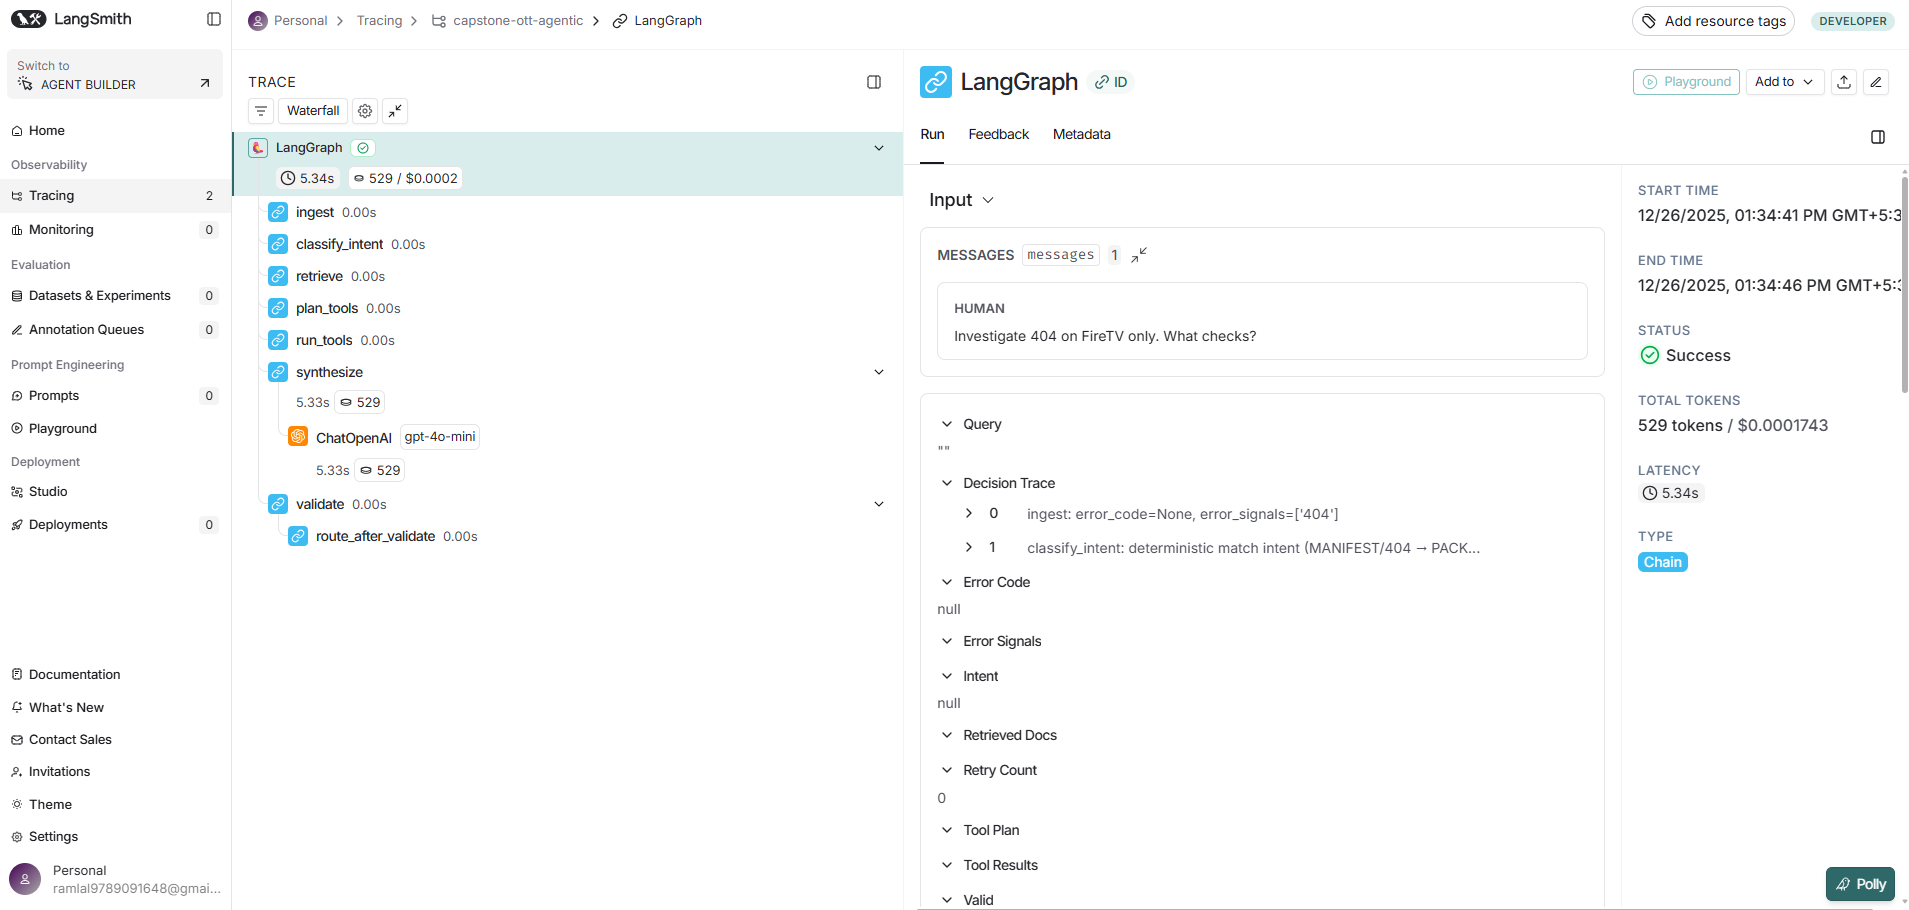

In [157]:
from IPython.display import Image, display
display(Image(filename="langsmith_ramlal_capstone_one_run.png"))

Multiple Run

In [158]:
# Optional batch suite
run_test_suite()


TEST: Investigate WV_LICENSE_403 on FireTV only. What checks?
=== FINAL STATE (selected) ===
query: Investigate WV_LICENSE_403 on FireTV only. What checks?
error_code: WV_LICENSE_403
error_signals: ['DRM']
intent: DRM
retrieved_doc_ids: ['D2', 'D3', 'D1']
tool_plan: ['lookup_error_kb', 'generate_checklist']
tool_results_keys: ['lookup_error_kb', 'generate_checklist']
retry_count: 0
valid: True

=== DECISION TRACE ===
- ingest: error_code=WV_LICENSE_403, error_signals=['DRM']
- classify_intent: deterministic match intent (WV_/DRM/LICENSE → DRM)
- retrieve: top_docs=['D2', 'D3', 'D1']
- plan_tools: intent=DRM, error_code=WV_LICENSE_403, error_signals=['DRM'], plan=['lookup_error_kb', 'generate_checklist']
- run_tools: executed=['lookup_error_kb', 'generate_checklist']
- synthesize: generated response (grounded template)
- validate: ok=True, reasons=[], cited=['D1', 'D2', 'D3']

TEST: Investigate CDN timeout on FireTV only. What checks?
=== FINAL STATE (selected) ===
query: Investigate C

LangSmith View For Batch run

In [159]:
from google.colab import files
files.upload()

Saving langsmith_ramlal_capstore_batch_run.png to langsmith_ramlal_capstore_batch_run.png


{'langsmith_ramlal_capstore_batch_run.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07x\x00\x00\x02w\x08\x06\x00\x00\x00v\x96\x80\xad\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x16%\x00\x00\x16%\x01IR$\xf0\x00\x00\xff\xa5IDATx^\xec\xddw|\x8d\xe7\xff\xc7\xf1W6\x89\xc4V\xc4.j\xab\xd2\xaa\xf2U\xa5\xa56-E\xfd\xcc\xb6\xb4\x94\x1a1Z\xa3j\xd5jK\xa8Y\xaaZU\xa5\xf6\xde\xd4\x9e\xb575B$\xb1Nd\x1c2~\x7f\x9c\x93\xe4\x9c[&AR\xef\xe7\xe3q?8\xd7u\xdd\xeb:\xf799\xd7\xfd\xb9\xaf\xebr\xb8~\xfdzt\xae\\\xb9pttDD\xd2\x1e??\x7f\xbc\xbds\x1b\x93EDDDDDDDDDDD\xe49\xe4\x08(\xb8+"""""""""""""\x92\x0e8FGG\x1b\xd3DDDDDDDDDDDDDD$\rR\x80WDDDDDDDDDDDDD$\x9d\xd0\xd8\xcc""""""""""""""\xe9\x84\x02\xbc""""""""""""""\xe9\x84\x02\xbc""""""""""""""\xe9\x84\x02\xbc""""""""""""""\xe9\x84\x02\xbc""""""""""""""\xe9\x84\x02\xbc""""""""""""""\xe9\x84\x83\x9f\x9f_t\xde\xbcy\x8d\xe9)\xf6\xcf\xe1\xc3\xac[\xbb\x9e\xfd\x07\x0er\xf1\xe2\xbf\x98L&c\x91G\x92/\x

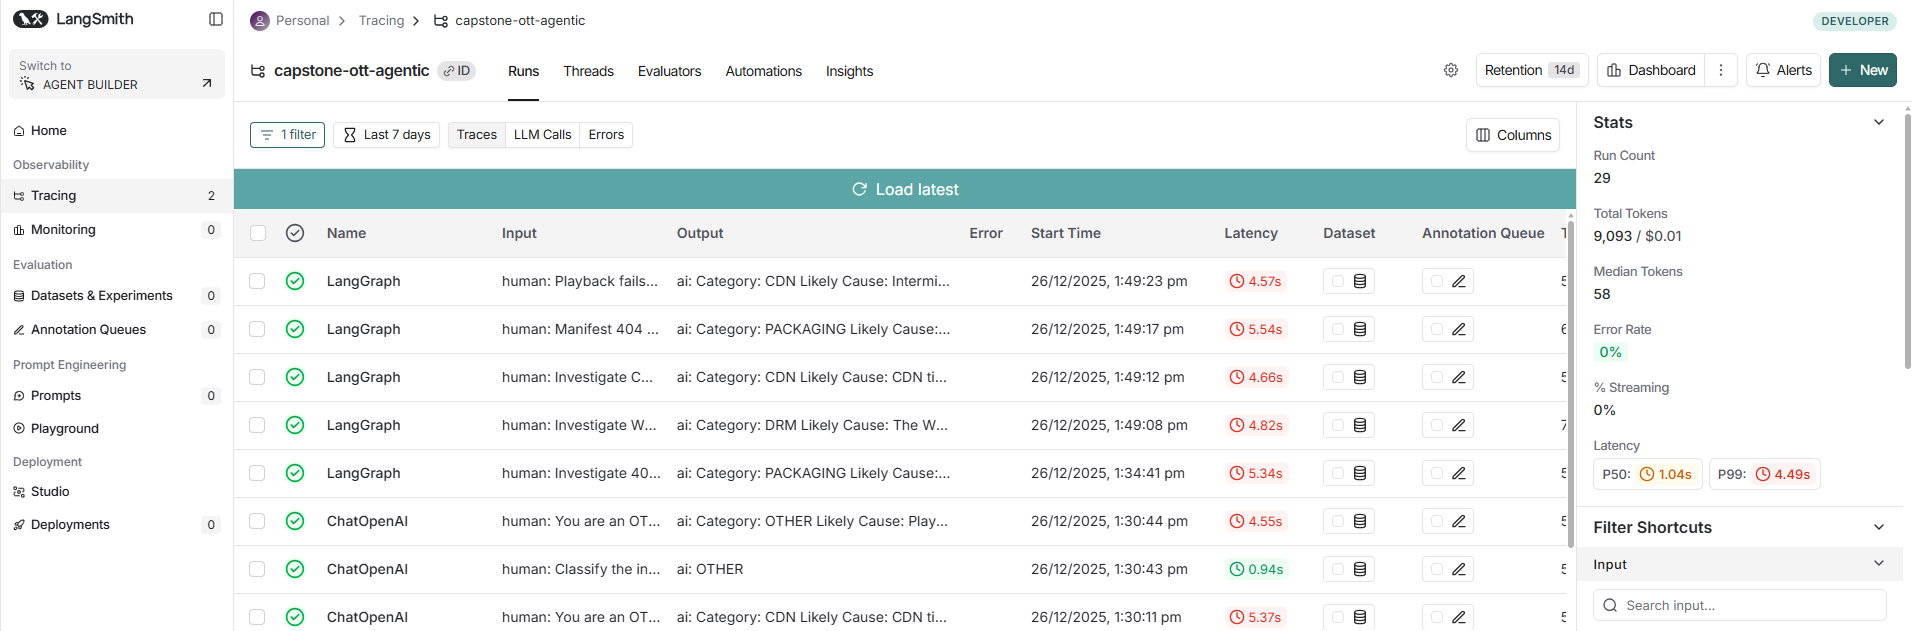

In [162]:
from IPython.display import Image, display
display(Image(filename="langsmith_ramlal_capstore_batch_run.png"))